# Heat-Mortality

In this tutorial we will walk you through and end-to-end heat-related mortality risk assessment. While the concept of calculating heat-related mortality is the same as for the other hazards and impacts, it differs in some ways. Most notabliy, the `exposure` (daily mortality counts) undergoes an annual cycle and is therefore time dependent. On the `hazard` and `vulnerability` side, it yields the advantage that we can build upon highly estabilshed workstreams and thus only need to do very little data processing. Still, all components are in line with the existing CLIMADA framework and can fully profit of its broader functionalities.

The methodology of modelling heat-related mortality in this tutorial is mainly a pythonic translation of the R based tutorial by [Vicedo-Cabrera et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6533172/).

The `ImpactHeat` class relies on three related classes for Hazard, Exposure and Vulnerability:

* `hazard/heat.py`, which handles the loading of temperature data from climate model output into the `climada.hazard` class.
    
* `exposures/daily_mortality.py` which loads & cleans daily mortality counts to match the `climada.exposures` class.

* `entity/impact_funcs/heat_mortality.py` which loads the location-specific relativ risk functions (vulnerability curves)

## Outline
* [**Part 1:**](#Part1) **Setting up the hazard**
    * [**1.1**](#Part1.1) Loading large ensemble climate data
    * [**1.2**](#Part1.2) Bias-correction using quantile mapping
* [**Part 2:**](#Part2) **Setting up the exposure**
    * 2.1 Loading and cleaning daily mortality counts
* [**Part 3:**](#Part3) **Setting up the relative risk curves**
    * 3.1 Loading RR curves into an ImpfSet
* [**Part 4:**](#Part4) **Calculating heat-related mortality impacts**
    * [**4.1**](#Part4.1) Impact calculation
    * [**4.2**](#Part4.2) Aggregation to annual levels
* [**Part 5:**](#Part5) **End-to-end climate risk analysis**

<a id='Part1'></a> 
## Part 1: Setting up the hazard

In order to assess heat stress or calculate heat-related mortality, a wide range of different indices is being proposed in the literature, ranging from mean temperature (on different time scales), min/max temperature (for maximum heat stress in the afternoon or lack of cooling in the night), to various indices that incorporate humidity and/or radiation and ventilation (wet-blub temperature, wet-bulb global temperature (WBGT), Universal Thermal Climate Index (UTCI)). However, no index has proven to be superior for modelling heat mortality. Therefore, we rely on the simplest and most established temperature variable, which is *daily mean temperature*.
 
For our risk assessment we rely on *single model initial condition large ensembles (SMILE)*. This is an approach, in which a climate model is run several times with different initial conditions but with the same climate forcing. Hence, it is well suited to display the natural variability of temperature and therefore also extremes. Furtheremore, it yields the advantage that it is direct climate model output and therefore does not require any statistical extrapolation for extremes and is physically consistant, also accross locations.

SMILE data is available openly on https://www.cesm.ucar.edu/projects/community-projects/MMLEA/



<a id='Part1.1'></a> 
### Part 1.1:  Loading SMILE data

As this approach is soon very data intensive, it is recommended to pre-process climate model data outside of python/CLIMADA using [Climate Data Operators (CDO)](https://code.mpimet.mpg.de/projects/cdo/). Please note that the module works with a 365-day per year calender (which needs to be correct for in some climate models). The temperature data is then set up in the hazard class `Heat`using the method `from_SMILE()` which requires a filelist of SMILE data files as input.

In [1]:
import numpy as np
import pandas as pd
import glob
import os

# data path for files of SMILE data from CanESM2 (50 ensemble members)
DP = '/Users/sam/Library/CloudStorage/OneDrive-ETHZurich/WCR/Projects/Heat/Data/Tutorial/'
filelist = [f for f in glob.glob(os.path.join(DP, 'CanESM2/'"*.nc"))]

# we load temperature data for Zurich (CH) and Geneva (CH) from 01.01.2000 to 31.12.2009
lat_ZRH = 47.3769; lon_ZRH = 8.5417
lat_GVA = 46.2044; lon_GVA = 6.1432
lats = np.array([lat_ZRH, lat_GVA]); lons = np.array([lon_ZRH, lon_GVA])

# set up hazard heat object and load data
from climada_petals.hazard.heat import Heat
ht = Heat.from_SMILE(filelist, lats, lons, t_start='2000-01-01', t_end='2009-12-31')
print('Shape of the intensity matrix is:')
print(ht.intensity.shape)


Start with loading and slicing large ensemble members
(0/50)
(10/50)
(20/50)
(30/50)
(40/50)
No bias correction is performed.
Shape of the intensity matrix is:
(182500, 2)


/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:195: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  haz.date = np.tile(data_per.columns.to_datetimeindex(), len(filelist))
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:198: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  len(data_per

The new `Heat`object has all the `climada.hazard` attributes. Events are defined as days (in a 365-day calendar). Hence, in our case the intensity matrix should be of the size 2 x 182'500 (182'500 = 365 days x 10 years x 50 ensemble members). To store the information of the ensemble member, the `Heat` class includes the attibute `Heat.ens_member`.

In order to visualize the spread of the different ensemble members, we can plot the temperature density of each member.

Text(0, 0.5, 'Density')

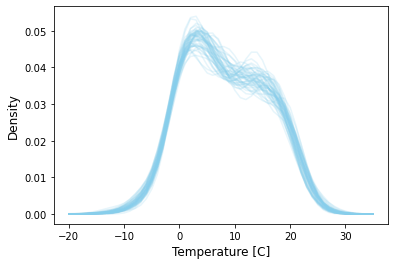

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure()
inten_zrh = ht.intensity.toarray()[:,0]-273.15 # correct Kelvin to Celsius

bins=np.linspace(-20, 35, 56)
for i in range(len(filelist)):
    inten_mem = inten_zrh[np.where(ht.ens_member==i)]
    density = stats.gaussian_kde(inten_mem)
    plt.plot(bins, density(bins), color="skyblue", alpha=0.2)
plt.xlabel("Temperature [C]", fontsize=12)
plt.ylabel("Density", fontsize=12)


<a id='Part1.2'></a> 
### Part 1.2:  Performing bias correction using quantile mapping

The temperature of a city can easily deviate by a degree Celsius from the temperature of the nearest-neighbour gridpoint of climate model output. Therefore we need to perform bias-correction, as such a deviation might hide a whole climate-change signal. A quantile mapping bias correction methodology is already built into the `Heat.from_SMILE()` methodology. This code is a slightly simplified version of the method published by Rajczak et al. (2016). doi:10.1002/joc.4417 and is available in R under https://github.com/SvenKotlarski/qmCH2018. We calibrate one correction term for the whole ensemble. This ensures, that the spread between ensembles is contained.

To perform bias-correction we need observational temperature data. Ideally, this is the same temperature data with which the vulnerability curve is calibrate (see Part 3). We therefore first load the observational data into a a list of pd.Dataframes() and then re-load the SMILE data to retrive a bias-corrected heat hazard object.

In [3]:
# load obs data
obs_zrh = pd.read_csv(os.path.join(DP, 'obs_zrh.csv'"))
obs_gva = pd.read_csv(os.path.join(DP, 'obs_gva.csv'"))
# make sure that the date column is in pd.Datetime format
obs_zrh.date = pd.to_datetime(obs_zrh.date)
obs_gva.date = pd.to_datetime(obs_gva.date)
temp_obs = list([obs_zrh, obs_gva]) # each pd.df needs a column 'date' and 'temp'

# set up bias corrected 
ht_bc = Heat.from_SMILE(filelist, lats, lons, temp_obs, '2000-01-01', '2009-12-31')


Start with loading and slicing large ensemble members
(0/50)
(10/50)
(20/50)
(30/50)
(40/50)
Start with bias correction


/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:195: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  haz.date = np.tile(data_per.columns.to_datetimeindex(), len(filelist))
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:198: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  len(data_per

Let's check if the bias corrected data now matches the observational data (small difference might occur, as the model data covers a different time span then the observational data)

Text(0, 0.5, 'Density')

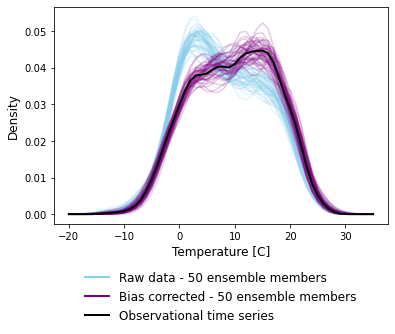

In [4]:
##### plt.figure()
inten_zrh = ht.intensity.toarray()[:,0]-273.15 # correct Kelvin to Celsius
bins=np.linspace(-20, 35, 56)

# plot raw data
for i in range(len(filelist)):
    inten_mem = inten_zrh[np.where(ht.ens_member==i)]
    density = stats.gaussian_kde(inten_mem)
    plt.plot(bins, density(bins), color="skyblue", alpha=0.2)
inten_zrh_bc = ht_bc.intensity.toarray()[:,0]

# plot bias corrected data
for i in range(len(filelist)):
    inten_mem = inten_zrh_bc[np.where(ht.ens_member==i)]
    density = stats.gaussian_kde(inten_mem)
    plt.plot(bins, density(bins), color="purple", alpha=0.2)

# obs data
density = stats.gaussian_kde(obs_zrh.temp)
plt.plot(bins, density(bins), color="black", linewidth=2)

# legend
p1 = plt.plot(np.NaN, np.NaN, color="skyblue", linewidth=2)
p2 = plt.plot(np.NaN, np.NaN, color="purple", linewidth=2)
p3 = plt.plot(np.NaN, np.NaN, color="black", linewidth=2)
plt.legend([p1[0], p2[0], p3[0]],
           ['Raw data - 50 ensemble members',
            'Bias corrected - 50 ensemble members',
            'Observational time series'],
           bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=1,
           fontsize=12, frameon=False)    
plt.xlabel("Temperature [C]", fontsize=12)
plt.ylabel("Density", fontsize=12)


<a id='Part2'></a> 
## Part 2: Setting up the exposure

In order to hold up the CLIMADA logic, our exposure component is here depicted as daily mortality counts. This is somewhat counterintuitive, as normally the expected exposure would be a population count. However, to easily reflect on the annual cycle of mortality as well as location and demographic specific properties, local daily mortality counts serve as our exposure.

We load daily mean mortality data into an exposure class and clean for missing values and leap years (again, we use a 365 day calendar).

In [5]:
# we already loaded the relevant data above. We need a list (in line with lat/lon) of pd.df
# that contain a column 'date' and 'death'
from climada_petals.entity.exposures.daily_mortality import DailyMortality
mort = DailyMortality.from_pandas_list(temp_obs, lats, lons)
print(mort.gdf)

2022-07-25 16:18:33,280 - climada.util.coordinates - INFO - Setting geometry points.
2022-07-25 16:18:33,310 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2022-07-25 16:18:33,311 - climada.entity.exposures.base - INFO - cover not set.
2022-07-25 16:18:33,311 - climada.entity.exposures.base - INFO - deductible not set.
2022-07-25 16:18:33,312 - climada.entity.exposures.base - INFO - region_id not set.
2022-07-25 16:18:33,312 - climada.entity.exposures.base - INFO - centr_ not set.
         value  latitude  longitude impf_ category_id  \
0    13.105263   47.3769     8.5417     0           1   
1    12.105263   47.3769     8.5417     0           2   
2    11.684211   47.3769     8.5417     0           3   
3    12.315789   47.3769     8.5417     0           4   
4    12.526316   47.3769     8.5417     0           5   
..         ...       ...        ...   ...         ...   
360   4.105263   46.2044     6.1432     1         361   
361   4.894737   46.2044     6.1432

Mean daily mortaliy counts are now stored as an `Exposure`. Each location is assigned with its own `impf_` while the day of the year for each mean mortality value is depicited in the `category_id`. Therefore we receive 730 (2 x 365) entries in the `exposure.gdf` data frame.
We can quickly visualize our `DailyMortality` for Zurich.

Text(0.5, 1.0, 'Mean daily mortality in Zurich')

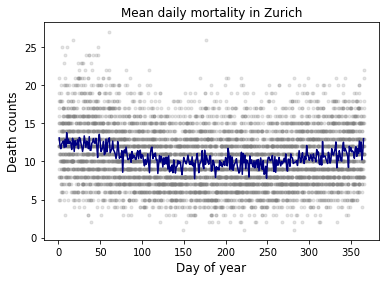

In [6]:
# removing leap days
date_series = pd.to_datetime(obs_zrh.date)
idx_leap_day = np.where((date_series.dt.is_leap_year.values==True) & \
                        (date_series.dt.day_of_year.values==60))[0]
zrh_clean = obs_zrh.drop(idx_leap_day)
mort_years = np.reshape(zrh_clean.deaths.values, [365, -1], 'F')

# plotting all mortality counts as gray dots, final exposure as blue line
plt.figure()
for i in range(mort_years.shape[1]):
    plt.plot(np.arange(1,366,1), mort_years[:,i], '.', color='gray', alpha=0.2)
plt.plot(np.arange(1,366,1), mort.gdf.value[mort.gdf.impf_==0], color='navy')
plt.xlabel("Day of year", fontsize=12)
plt.ylabel("Death counts", fontsize=12)
plt.title("Mean daily mortality in Zurich")


<a id='Part3'></a> 
## Part 3: Setting up the relative risk curves

The epidemiological analysis to quantify the association between heat and mortality in each location relies on a two-stage approach which is commonly used in multi-location time-series studies. It is best performed within the R software environment using the open-source packages dnlm and mixmeta and is also explained in the turotial by [Vicedo-Cabrera et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6533172/).

The resulting relationships express the relative risk of death against an optimum temperature as a function of the daily mean temperature. These functions reflect the complex relationship between temperature and all-cause mortality by accounting for the delayed and nonlinear impact that heat hinges on human health.
**Heat-related mortality is then defined as the daily excess mortality above the location-specific temperature of minimum mortality (MMT).**

For simplicity, we transfer the resulting relative risk curves from the R based analysis to python using csv files which we then incorporate into the `ImpfSetHeat` class. Please note, that these relationships are highly location specific and cannot be easily transferred between locations.

Daily mortality data is often not publicly available. However, data for various locations in Switzerland and in the UK can be found [here](https://boris.unibe.ch/149875/).

2022-07-25 16:18:40,437 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


array([<AxesSubplot:title={'center':'Heat 0: Relativ risk for'}, xlabel='Intensity (C)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'Heat 1: Relativ risk for'}, xlabel='Intensity (C)', ylabel='Impact (%)'>],
      dtype=object)

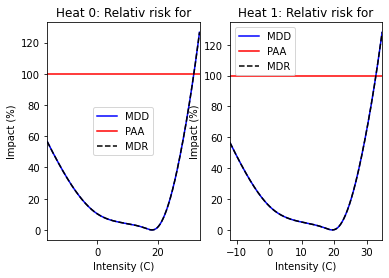

In [7]:
# load RR data
rr_zrh = pd.read_csv(os.path.join(DP, 'rr_zrh.csv'"))
rr_gva = pd.read_csv(os.path.join(DP, 'rr_gva.csv'"))
rr_list = list([rr_zrh, rr_gva]) # make sure the order of location is the same as the hazard and exposure

# set up impf set
from climada_petals.entity.impact_funcs.heat_mortality import ImpfSetHeat
impf_heat = ImpfSetHeat.from_pandas_list(rr_list)
impf_heat.plot()


<a id='Part4'></a> 
## Part 4: Calculating heat-related mortality impacts

<a id='Part4.1'></a> 
### Part 4.1: Impact calculation

To quantify the heat-related mortality impacts, the epidemiological analysis needs to be combined with the SMILE climate data. The excess mortality is calculated by multiplying the location- and day-of-the-year specific average mortality counts with the relative risk, given a daily mean temperature. As this introduces a time-dependent exposure, we can not fully rely on CLIMADAs default `Impact` class but need to introduce the `ImpactHeat` class.

As explained above, we account all excess mortality above MMT as heat-related mortality. We therefore first remove all events in our hazard below MMT using the function `set_MMT`. This also speeds up the imapct calculation. The same function also be used to calculate cold-related mortality. Note that one can set the MMT directly when creating the hazard.

In [8]:
# removing temperature values in hazard below MMT
MMT = np.array([rr_zrh.temp.values[rr_zrh.RRfit==rr_zrh.RRfit.min()][0],
                rr_gva.temp.values[rr_gva.RRfit==rr_gva.RRfit.min()][0]])
ht_bc.set_MMT(MMT, kind='heat')
# calculating impacts
from climada_petals.engine.impact_heat import ImpactHeat
imp_heat = ImpactHeat()
imp_heat.calc_heat_mort(mort, impf_heat, ht_bc, save_mat=True)
print(imp_heat.imp_mat.size)

2022-07-25 16:18:45,847 - climada.entity.exposures.base - INFO - Matching 730 exposures with 2 centroids.
2022-07-25 16:18:45,859 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-07-25 16:18:45,871 - climada.engine.impact - INFO - Calculating damage for 730 assets (>0) and 182500 events.
2022-07-25 16:18:45,872 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard Heat. Using the anonymous 'impf_' column.
55368


Heat-related mortality counts are calculated for each event (day).

<a id='Part4.2'></a> 
### Part 4.2: Aggregation to annual levels

Finally, we can aggregate our daily impacts to annual level and produce the traditional risk analysis tools such as exceedance frequency curves

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (# lives)'>

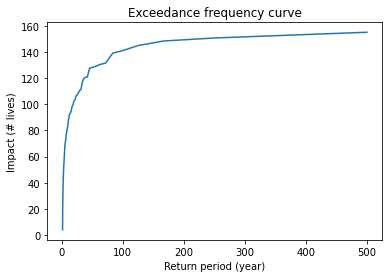

In [9]:
imp_heat.aggregate_to_years(save_mat=True)
freq_curve = imp_heat.calc_freq_curve() # impact exceedance frequency curve
freq_curve.plot()

<a id='Part5'></a> 
## Part 5: End-to-end climate risk analysis

Based on the same logic as above, we perform a quick climate risk analysis for heat-related mortality in Zurich and Geneva.

In [12]:
# load hazard for two 20-year climate periods & calc impacts
ht_now = Heat.from_SMILE(filelist, lats, lons, temp_obs, '2010-01-01', '2029-12-31', MMT)
ht_fut = Heat.from_SMILE(filelist, lats, lons, temp_obs, '2030-01-01', '2049-12-31', MMT)

# calculate impacts. We keep exposure and vulnerability constant
imp_now = ImpactHeat()
imp_now.calc_heat_mort(mort, impf_heat, ht_now, save_mat=True)
imp_now.aggregate_to_years(save_mat=True)

imp_fut = ImpactHeat()
imp_fut.calc_heat_mort(mort, impf_heat, ht_fut, save_mat=True)
imp_fut.aggregate_to_years(save_mat=True)


Start with loading and slicing large ensemble members
(0/50)
(10/50)
(20/50)
(30/50)
(40/50)
Start with bias correction


/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:195: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  haz.date = np.tile(data_per.columns.to_datetimeindex(), len(filelist))
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:198: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  len(data_per

Start with loading and slicing large ensemble members
(0/50)
(10/50)
(20/50)
(30/50)
(40/50)
Start with bias correction


/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:195: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  haz.date = np.tile(data_per.columns.to_datetimeindex(), len(filelist))
/Users/sam/Documents/GitHub/climada_petals/climada_petals/hazard/heat.py:198: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  len(data_per

2022-07-25 16:26:24,277 - climada.engine.impact - INFO - Exposures matching centroids found in centr_Heat
2022-07-25 16:26:24,284 - climada.engine.impact - INFO - Calculating damage for 730 assets (>0) and 365000 events.
2022-07-25 16:26:24,285 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard Heat. Using the anonymous 'impf_' column.
2022-07-25 16:27:51,231 - climada.engine.impact - INFO - Exposures matching centroids found in centr_Heat
2022-07-25 16:27:51,256 - climada.engine.impact - INFO - Calculating damage for 730 assets (>0) and 365000 events.
2022-07-25 16:27:51,258 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard Heat. Using the anonymous 'impf_' column.


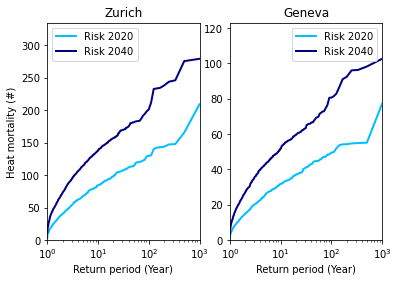

In [14]:
# calc & plot ExFreqCurve for all locations & periods
def calc_exfreq(imp, freq):
    sort_idxs = np.argsort(imp)[::-1]
    # Calculate exceedence frequency
    exceed_freq = np.cumsum(freq[sort_idxs])
    # Set return period and imact exceeding frequency
    return_per = 1 / exceed_freq[::-1]
    impact = imp[sort_idxs][::-1]
    
    return impact, return_per
# calculate location levels EFCs
imp_zrh_now, rp = calc_exfreq(imp_now.imp_mat.toarray()[:,0], imp_now.frequency)
imp_gva_now, _ = calc_exfreq(imp_now.imp_mat.toarray()[:,1], imp_now.frequency)
imp_zrh_fut, _ = calc_exfreq(imp_fut.imp_mat.toarray()[:,0], imp_fut.frequency)
imp_gva_fut, _ = calc_exfreq(imp_fut.imp_mat.toarray()[:,1], imp_fut.frequency)
    
# plot

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(rp, imp_zrh_now, color='deepskyblue', linewidth=2, label='Risk 2020')
ax1.plot(rp, imp_zrh_fut, color='navy', linewidth=2, label='Risk 2040')
ax1.set_title('Zurich')
ax1.set_xscale('log')
ax1.set_xlim(1,np.max(rp))
ax1.set_ylim(0,np.max(imp_zrh_fut)*1.2)
ax1.set_xlabel("Return period (Year)")
ax1.set_ylabel("Heat mortality (#)")
ax1.legend()

ax2.plot(rp, imp_gva_now, color='deepskyblue', linewidth=2, label='Risk 2020')
ax2.plot(rp, imp_gva_fut, color='navy', linewidth=2, label='Risk 2040')
ax2.set_title('Geneva')
ax2.set_xscale('log')
ax2.set_xlim(1,np.max(rp))
ax2.set_ylim(0,np.max(imp_gva_fut)*1.2)
ax2.set_xlabel("Return period (Year)")
ax2.set_ylabel("")
ax2.legend()